In [1]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

#import autokeras as ak
import matplotlib.pyplot as plt

import os
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimage

from sklearn.model_selection import train_test_split

%matplotlib inline

from keras.models import load_model
from keras.models import  Model
from keras.layers import Input, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from keras.wrappers.scikit_learn import KerasClassifier

import cv2
from tqdm import tqdm, tqdm_notebook

Using TensorFlow backend.


In [2]:
# data reading based on https://www.kaggle.com/seedlite/aerial-cactus-identification-using-keras/output
train_dir = "train"
test_dir = "test"
train_df = pd.read_csv('train.csv')

features = []
target = []
images = train_df['id'].values
for img_id in tqdm_notebook(images):
    features.append(cv2.imread(train_dir + "/" + img_id))    
    target.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])  
    
features = np.asarray(features)
features = features.astype('float32')
features /= 255
target = np.asarray(target)

In [17]:
features.shape

(17500, 32, 32, 3)

In [3]:
input_shape = (32, 32, 3)

model = Sequential([
    Conv2D(64, (3,3), input_shape=input_shape),
    MaxPool2D((2, 2)),
    
    Conv2D(128, (3,3)),
    MaxPool2D((2, 2)),
    
    Conv2D(256, (3,3)),
    MaxPool2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(.5),
    Dense(1, activation='sigmoid')    
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_3 (MaxP

In [6]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    
    Flatten(),
    
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1025      
Total params: 15,241,025
Trainable params: 526,337
Non-trainable params: 14,714,688
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 15750 samples, validate on 1750 samples
Epoch 1/15
15750/15750 [==============================] - 72s 5ms/step - loss: 0.1492 - acc: 0.9441 - val_loss: 0.0928 - val_acc: 0.9663
Epoch 2/15
15750/15750 [==============================] - 60s 4ms/step - loss: 0.1022 - acc: 0.9596 - val_loss: 0.0896 - val_acc: 0.9651
Epoch 3/15
15750/15750 [==============================] - 71s 4ms/step - loss: 0.0941 - acc: 0.9651 - val_loss: 0.0777 - val_acc: 0.9737
Epoch 4/15
15750/15750 [==============================] - 67s 4ms/step - loss: 0.0871 - acc: 0.9668 - val_loss: 0.1045 - val_acc: 0.9629
Epoch 5/15
15750/15750 [==============================] - 58s 4ms/step - loss: 0.0876 - acc: 0.9675 - val_loss: 0.0755 - val_acc: 0.9714
Epoch 6/15
15750/15750 [==============================] - 56s 4ms/step - loss: 0.0798 - acc: 0.9679 - val_loss: 0.0739 - val_acc: 0.9697
Epoch 7/15
15750/15750 [==============================] - 54s 3ms/step - loss: 0.

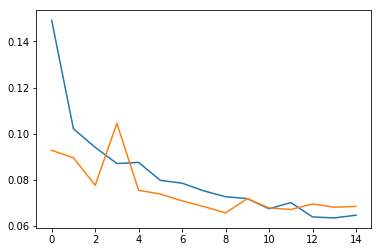

In [7]:
training = model.fit(features, target, validation_split=0.1, epochs=15)

# Visualizing the losses vs. epochs
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.show()